In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ================================
# STEP 1 — DOWNLOAD MARKET DATA
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# DATA LIMIT (very important)
# ------------------------------
START_DATE = "2015-01-01"   # change to "2020-01-01" if still slow

# ------------------------------
# Download data from Stooq
# ------------------------------
assets = {
    "SPY": "spy.us",
    "EFA": "efa.us",
    "AGG": "agg.us",
    "GLD": "gld.us",
    "VNQ": "vnq.us"
}

prices_list = []

for name, stooq_code in assets.items():
    url = f"https://stooq.com/q/d/l/?s={stooq_code}&i=d"
    df = pd.read_csv(url)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")[["Close"]].rename(columns={"Close": name})

    prices_list.append(df)

# Combine all assets
prices = pd.concat(prices_list, axis=1).sort_index()

# ------------------------------
# Limit sample (keeps project fast)
# ------------------------------
prices = prices.loc[START_DATE:].copy()

# Drop missing values after slicing
prices = prices.dropna()

print("Prices shape:", prices.shape)
print("Date range:", prices.index.min(), "to", prices.index.max())

prices.tail()


Prices shape: (2795, 5)
Date range: 2015-01-02 00:00:00 to 2026-02-12 00:00:00


,SPY,EFA,AGG,GLD,VNQ
Date,,,,,
2026-02-06,690.62,102.61,100.130,455.4600,92.25
2026-02-09,693.95,103.99,100.160,467.0300,92.64
2026-02-10,692.12,104.24,100.450,462.4000,93.88
2026-02-11,691.96,104.94,100.220,467.6300,93.36
2026-02-12,684.63,104.16,100.545,455.3699,93.45


In [5]:
returns = prices.pct_change().dropna()

print("Returns shape:", returns.shape)
returns.head()


# ================================
# Monthly Returns (for strategy)
# ================================
monthly_returns = returns.resample("M").apply(lambda x: (1 + x).prod() - 1)

print("Monthly returns shape:", monthly_returns.shape)
monthly_returns.head()


Returns shape: (2794, 5)
Monthly returns shape: (134, 5)


C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1250601887.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample("M").apply(lambda x: (1 + x).prod() - 1)


,SPY,EFA,AGG,GLD,VNQ
Date,,,,,
2015-01-31,-0.029203,0.010546,0.017504,0.082135,0.052693
2015-02-28,0.056255,0.063421,-0.008771,-0.059052,-0.036729
2015-03-31,-0.015671,-0.014306,0.003591,-0.021522,0.017309
2015-04-30,0.009811,0.036449,-0.004660,-0.001672,-0.058529
2015-05-31,0.012824,0.001971,-0.004569,0.005552,-0.002998


Regime counts:
SPY
0    1407
1    1387
Name: count, dtype: int64


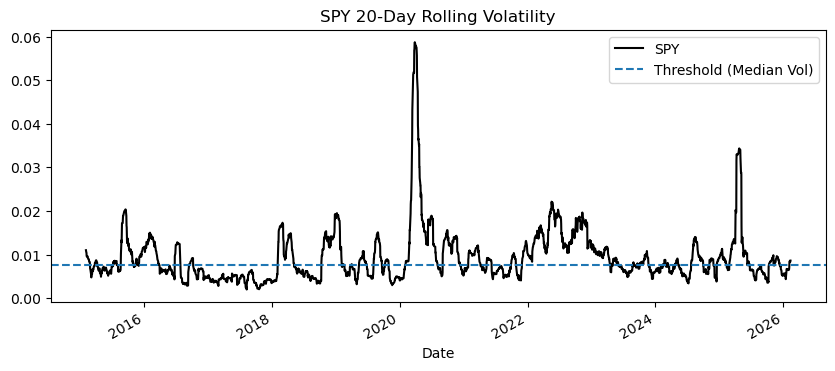

In [6]:
# ==========================================
# STEP 3 — MARKET REGIME IDENTIFICATION
# ==========================================

# We use SPY (US equities) as market proxy
# Rolling volatility helps detect calm vs turbulent markets

# ------------------------------------------
# 20-day rolling volatility of SPY returns
# ------------------------------------------
# std() measures daily volatility
# 20 days ≈ 1 trading month (industry standard short-term risk)
vol20 = returns["SPY"].rolling(20).std()

# ------------------------------------------
# Threshold to split regimes
# ------------------------------------------
# Median volatility → simple but robust separation
# Above median → high-vol regime
# Below median → low-vol regime
threshold = vol20.median()

# ------------------------------------------
# Create regime label
# ------------------------------------------
# 1 = High Volatility (risk-off environment)
# 0 = Low Volatility (risk-on environment)
regime = (vol20 > threshold).astype(int).dropna()

# Print regime distribution
print("Regime counts:")
print(regime.value_counts())

# ------------------------------------------
# Plot volatility and threshold
# ------------------------------------------
# Helps visualize when market enters stress regime
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
vol20.plot(title="SPY 20-Day Rolling Volatility", color="black")
plt.axhline(threshold, linestyle="--", label="Threshold (Median Vol)")
plt.legend()
plt.show()


In [9]:
# ==========================================
# STEP 4 — FEATURE ENGINEERING + ML MODEL
# (Corrected + Bulletproof Alignment)
# ==========================================

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------
# 4.1 Create Features (X)
# ------------------------------------------
# Features are built using information available at time t (today).
# We will use them to predict regime at time t+1 (tomorrow).
#
# Feature meanings:
# - vol20  : short-term risk proxy (rolling volatility)
# - mom60  : medium-term trend proxy (rolling mean return)
# - mkt_ret: today's market return (SPY)

features = pd.DataFrame(index=returns.index)
features["vol20"] = vol20
features["mom60"] = returns["SPY"].rolling(60).mean()
features["mkt_ret"] = returns["SPY"]

# Remove NaNs created by rolling windows (vol20 and mom60)
features = features.dropna()

# ------------------------------------------
# 4.2 Create Target (y): TOMORROW'S regime
# ------------------------------------------
# We want a realistic setup:
# X(t) -> y(t+1)
# i.e., use today's features to predict tomorrow's volatility regime.
y = regime.shift(-1)

# ------------------------------------------
# 4.3 Align X and y (Bulletproof Fix)
# ------------------------------------------
# Because rolling windows create missing values, X and y will not
# naturally line up. We align by index intersection, then:
# 1) drop NaNs from y (shift creates NaN at the end)
# 2) force X to use the final y index so lengths match exactly

common_idx = features.index.intersection(y.index)

X = features.loc[common_idx]
y = y.loc[common_idx]

# Drop NaNs in y, then align X to y index
y = y.dropna().astype(int)
X = X.loc[y.index]

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)
print("y counts:\n", y.value_counts())

# ------------------------------------------
# 4.4 Time-Series Train/Test Split (No shuffle)
# ------------------------------------------
# In finance we must preserve time order. This is safer than random splits.
split = int(len(X) * 0.70)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("\nTrain period:", X_train.index.min(), "to", X_train.index.max())
print("Test period :", X_test.index.min(), "to", X_test.index.max())

# ------------------------------------------
# 4.5 Train Random Forest Classifier
# ------------------------------------------
# Random Forest is robust for regime classification:
# - captures non-linear patterns
# - stable with noisy financial features
# - ensemble reduces overfitting

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    n_jobs=-1
)

model.fit(X_train, y_train)

# ------------------------------------------
# 4.6 Predict on Test set + Evaluate
# ------------------------------------------
pred = model.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, pred))

# (Optional) Save predictions for next steps (portfolio logic)
pred_series = pd.Series(pred, index=X_test.index, name="pred_regime")
pred_series.head()


Final X shape: (2734, 3)
Final y shape: (2734,)
y counts:
 SPY
0    1368
1    1366
Name: count, dtype: int64

Train period: 2015-03-31 00:00:00 to 2022-11-01 00:00:00
Test period : 2022-11-02 00:00:00 to 2026-02-11 00:00:00

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       400
           1       0.95      0.94      0.95       421

    accuracy                           0.95       821
   macro avg       0.95      0.95      0.95       821
weighted avg       0.95      0.95      0.95       821

Confusion matrix:
[[381  19]
 [ 24 397]]


Date
2022-11-02    1
2022-11-03    1
2022-11-04    1
2022-11-07    1
2022-11-08    1
Name: pred_regime, dtype: int64

C:\Users\himal\AppData\Local\Temp\ipykernel_22068\2733297003.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_signal = pred_full.resample("M").last()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\2733297003.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.loc[monthly_signal.index.min():].resample("M").apply(lambda x: (1+x).prod() - 1)


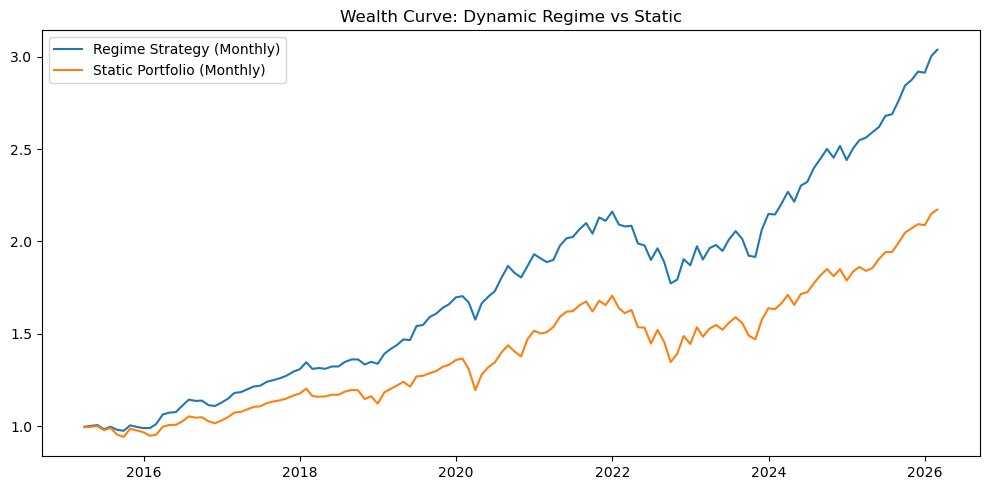

(Date
 2015-03-31   -0.003152
 2015-04-30    0.004262
 2015-05-31    0.004865
 2015-06-30   -0.022689
 2015-07-31    0.013935
 Freq: ME, Name: Dynamic, dtype: float64,
 Date
 2015-03-31   -0.006160
 2015-04-30    0.002815
 2015-05-31    0.003126
 2015-06-30   -0.021794
 2015-07-31    0.012583
 Freq: ME, Name: Static, dtype: float64)

In [10]:
# ==========================================
# STEP 5 — PORTFOLIO BACKTEST (DYNAMIC vs STATIC)
# (No leakage + Monthly rebalance)
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 5.1 Define portfolio weights
# -----------------------------
# Low-vol regime: higher equity exposure (risk-on)
weights_low_vol = {"SPY":0.40, "EFA":0.20, "AGG":0.20, "GLD":0.10, "VNQ":0.10}

# High-vol regime: defensive tilt (risk-off)
weights_high_vol = {"SPY":0.15, "EFA":0.10, "AGG":0.45, "GLD":0.20, "VNQ":0.10}

# Static benchmark (constant mix)
static_weights = {"SPY":0.30, "EFA":0.20, "AGG":0.30, "GLD":0.10, "VNQ":0.10}

# -----------------------------
# 5.2 Predict TOMORROW regime for all available dates
# -----------------------------
# We must predict on the SAME feature set used for model training setup (X)
# If you used Step 4 code, you already have X and y aligned.
#
# We'll produce daily predictions, then use month-end prediction to set next month's weights.

pred_full = pd.Series(model.predict(X), index=X.index, name="pred_regime")

# Convert daily predictions to month-end signal
monthly_signal = pred_full.resample("M").last()

# -----------------------------
# 5.3 Convert daily asset returns to monthly asset returns
# -----------------------------
# Monthly return = product(1+daily) - 1 (compounding)
monthly_returns = returns.loc[monthly_signal.index.min():].resample("M").apply(lambda x: (1+x).prod() - 1)

# Align monthly returns to monthly signals
common_m = monthly_returns.index.intersection(monthly_signal.index)
monthly_returns = monthly_returns.loc[common_m]
monthly_signal  = monthly_signal.loc[common_m]

# -----------------------------
# 5.4 Compute strategy monthly returns
# -----------------------------
dyn_monthly = []
static_monthly = []

for dt in common_m:
    # static portfolio
    r_static = sum(static_weights[a] * monthly_returns.loc[dt, a] for a in static_weights)
    static_monthly.append(r_static)

    # dynamic regime portfolio
    w = weights_low_vol if monthly_signal.loc[dt] == 0 else weights_high_vol
    r_dyn = sum(w[a] * monthly_returns.loc[dt, a] for a in w)
    dyn_monthly.append(r_dyn)

dyn_monthly = pd.Series(dyn_monthly, index=common_m, name="Dynamic")
static_monthly = pd.Series(static_monthly, index=common_m, name="Static")

# -----------------------------
# 5.5 Plot wealth curves
# -----------------------------
cum_dynamic = (1 + dyn_monthly).cumprod()
cum_static  = (1 + static_monthly).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_dynamic, label="Regime Strategy (Monthly)")
plt.plot(cum_static, label="Static Portfolio (Monthly)")
plt.title("Wealth Curve: Dynamic Regime vs Static")
plt.legend()
plt.tight_layout()
plt.show()

dyn_monthly.head(), static_monthly.head()


In [11]:
# ==========================================
# STEP 6 — PERFORMANCE METRICS (MONTHLY)
# ==========================================

def sharpe_monthly(r):
    """Annualized Sharpe using monthly returns"""
    return (r.mean() / r.std()) * np.sqrt(12)

def cagr_monthly(r):
    """Compound Annual Growth Rate from monthly returns"""
    wealth = (1 + r).prod()
    years = len(r) / 12
    return wealth**(1/years) - 1

def max_drawdown_from_returns(r):
    """Max drawdown computed from returns series"""
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    return dd.min()

# Use MONTHLY returns from Step 5
print("Dynamic Sharpe (monthly):", sharpe_monthly(dyn_monthly))
print("Static Sharpe  (monthly):", sharpe_monthly(static_monthly))

print("Dynamic CAGR:", cagr_monthly(dyn_monthly))
print("Static CAGR :", cagr_monthly(static_monthly))

print("Dynamic Max DD:", max_drawdown_from_returns(dyn_monthly))
print("Static Max DD :", max_drawdown_from_returns(static_monthly))


Dynamic Sharpe (monthly): 1.2642178006818185
Static Sharpe  (monthly): 0.7782179079960324
Dynamic CAGR: 0.10631802301380566
Static CAGR : 0.07308769756964506
Dynamic Max DD: -0.17975968054339309
Static Max DD : -0.2105524199958153


In [12]:
# y(t+1) = tomorrow regime
y = regime.shift(-1)

# Keep only common dates
common_idx = features.index.intersection(y.index)
X = features.loc[common_idx]
y = y.loc[common_idx]

# Drop NaNs then align X to y
y = y.dropna().astype(int)
X = X.loc[y.index]


In [13]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# pred/proba series for full X index
pred_oos = pd.Series(index=X.index, dtype="float")
proba_oos = pd.Series(index=X.index, dtype="float")

start_train = 750  # with 2015+ data, 750 is fine (≈3 years trading days)

# retrain dates = month-end dates available in X
retrain_dates = X.resample("M").last().index
retrain_dates = retrain_dates[retrain_dates.isin(X.index)]

for d in retrain_dates:
    i = X.index.get_loc(d)
    if i < start_train:
        continue

    # train on everything up to date d (exclusive of future)
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]

    model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        min_samples_leaf=5,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # predict from d until next retrain date
    next_ds = retrain_dates[retrain_dates > d]
    end = X.index.get_loc(next_ds[0]) if len(next_ds) else len(X)

    X_block = X.iloc[i:end]
    pred_oos.iloc[i:end] = model.predict(X_block)
    proba_oos.iloc[i:end] = model.predict_proba(X_block)[:, 1]  # P(high-vol)

pred_oos = pred_oos.dropna().astype(int)
proba_oos = proba_oos.dropna()

print("OOS pred counts:\n", pred_oos.value_counts())
print("\nOOS proba summary:\n", proba_oos.describe())


C:\Users\himal\AppData\Local\Temp\ipykernel_22068\248560314.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  retrain_dates = X.resample("M").last().index


OOS pred counts:
 1    1104
0     854
Name: count, dtype: int64

OOS proba summary:
 count    1958.000000
mean        0.563690
std         0.455573
min         0.000000
25%         0.020411
50%         0.908895
75%         0.983440
max         1.000000
dtype: float64


In [14]:
# ==========================================
# STEP 5 — MONTHLY REGIME STRATEGY + COSTS
# (Correct timing: signal -> next month allocation)
# ==========================================

# -----------------------------
# 5.1 Convert daily predictions to month-end signal
# -----------------------------
# pred_series is daily OOS predictions (0/1)
# We take the last prediction of each month.
# IMPORTANT: shift(1) so that month-end signal is used for NEXT month (no look-ahead).
monthly_regime = pred_series.resample("M").last().shift(1).dropna()

# -----------------------------
# 5.2 Convert daily asset returns to monthly returns
# -----------------------------
monthly_returns = returns.resample("M").apply(lambda x: (1 + x).prod() - 1)

# Align monthly returns to the regime signal dates
common_idx = monthly_returns.index.intersection(monthly_regime.index)
monthly_returns = monthly_returns.loc[common_idx]
monthly_regime  = monthly_regime.loc[common_idx]

# -----------------------------
# 5.3 Define allocations for each regime
# -----------------------------
weights_low_vol  = {"SPY":0.40, "EFA":0.20, "AGG":0.20, "GLD":0.10, "VNQ":0.10}
weights_high_vol = {"SPY":0.15, "EFA":0.10, "AGG":0.45, "GLD":0.20, "VNQ":0.10}

# -----------------------------
# 5.4 Compute dynamic strategy monthly returns
# -----------------------------
dyn_monthly = []

for dt in monthly_regime.index:
    w = weights_low_vol if monthly_regime.loc[dt] == 0 else weights_high_vol
    r = sum(w[a] * monthly_returns.loc[dt, a] for a in w)
    dyn_monthly.append(r)

dyn_monthly = pd.Series(dyn_monthly, index=monthly_regime.index, name="Dynamic_gross")

# -----------------------------
# 5.5 Transaction cost model (simple but realistic)
# -----------------------------
# We charge cost when regime switches (meaning we rebalance aggressively).
# tcost = 0.10% per switch
tcost = 0.001

# switch = 1 when regime changes vs previous month, else 0
switch = monthly_regime.diff().abs().fillna(0)

# net returns after transaction costs
dyn_monthly_net = (dyn_monthly - switch * tcost).rename("Dynamic_net")

# -----------------------------
# 5.6 Static benchmark portfolio (constant weights)
# -----------------------------
static_weights = {"SPY":0.30, "EFA":0.20, "AGG":0.30, "GLD":0.10, "VNQ":0.10}

static_monthly = monthly_returns.apply(
    lambda row: sum(static_weights[a] * row[a] for a in static_weights),
    axis=1
).rename("Static")

dyn_monthly_net.head(), static_monthly.head()


C:\Users\himal\AppData\Local\Temp\ipykernel_22068\175227933.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_regime = pred_series.resample("M").last().shift(1).dropna()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\175227933.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample("M").apply(lambda x: (1 + x).prod() - 1)


(Date
 2022-12-31   -0.017298
 2023-01-31    0.055344
 2023-02-28   -0.036513
 2023-03-31    0.032172
 2023-04-30    0.008816
 Freq: ME, Name: Dynamic_net, dtype: float64,
 Date
 2022-12-31   -0.029094
 2023-01-31    0.063026
 2023-02-28   -0.033637
 2023-03-31    0.029356
 2023-04-30    0.012804
 Freq: ME, Name: Static, dtype: float64)

                 CAGR  Sharpe  Sortino  Max Drawdown  Calmar
Dynamic (net)  0.1213  1.4254   2.4323       -0.0783  1.5492
Static         0.1234  1.3468   2.7292       -0.0754  1.6361


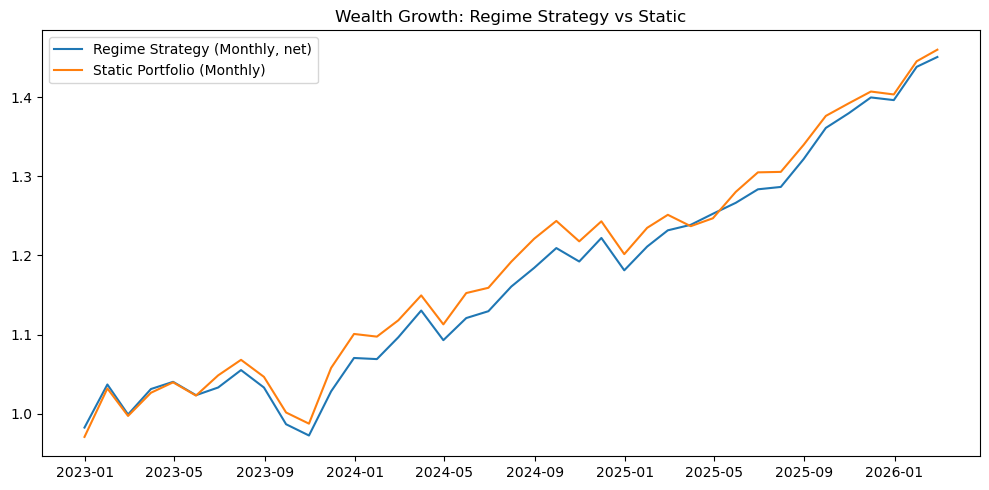

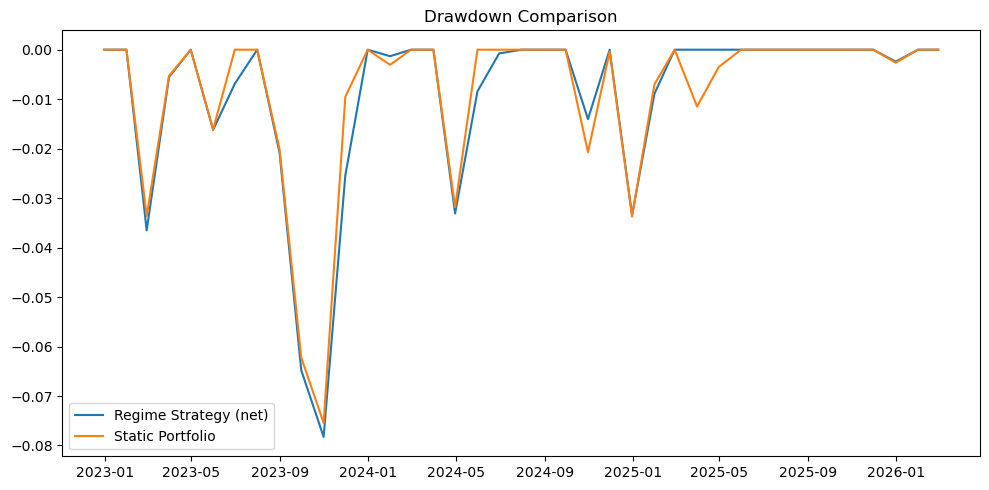

In [15]:
import os

# ==========================================
# STEP 6 — PERFORMANCE METRICS + PLOTS
# ==========================================

os.makedirs("results", exist_ok=True)

def sharpe_monthly(r):
    return (r.mean() / r.std()) * np.sqrt(12)

def sortino_monthly(r):
    downside = r[r < 0].std()
    return (r.mean() / downside) * np.sqrt(12)

def cagr_monthly(r):
    wealth = (1 + r).prod()
    years = len(r) / 12
    return wealth**(1/years) - 1

def max_drawdown_from_returns(r):
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    dd = (wealth / peak) - 1
    return dd.min()

def calmar(r):
    return cagr_monthly(r) / abs(max_drawdown_from_returns(r))

# ---- Metrics table
summary = pd.DataFrame({
    "CAGR": [cagr_monthly(dyn_monthly_net), cagr_monthly(static_monthly)],
    "Sharpe": [sharpe_monthly(dyn_monthly_net), sharpe_monthly(static_monthly)],
    "Sortino": [sortino_monthly(dyn_monthly_net), sortino_monthly(static_monthly)],
    "Max Drawdown": [max_drawdown_from_returns(dyn_monthly_net), max_drawdown_from_returns(static_monthly)],
    "Calmar": [calmar(dyn_monthly_net), calmar(static_monthly)],
}, index=["Dynamic (net)", "Static"])

print(summary.round(4))

# ---- Wealth curves
wealth_dyn = (1 + dyn_monthly_net).cumprod()
wealth_static = (1 + static_monthly).cumprod()

plt.figure(figsize=(10,5))
plt.plot(wealth_dyn, label="Regime Strategy (Monthly, net)")
plt.plot(wealth_static, label="Static Portfolio (Monthly)")
plt.legend()
plt.title("Wealth Growth: Regime Strategy vs Static")
plt.tight_layout()
plt.savefig("results/wealth_curve_upgrade.png", dpi=200)
plt.show()

# ---- Drawdown curves
def drawdown_series(r):
    w = (1 + r).cumprod()
    peak = w.cummax()
    return (w / peak) - 1

dd_dyn = drawdown_series(dyn_monthly_net)
dd_static = drawdown_series(static_monthly)

plt.figure(figsize=(10,5))
plt.plot(dd_dyn, label="Regime Strategy (net)")
plt.plot(dd_static, label="Static Portfolio")
plt.legend()
plt.title("Drawdown Comparison")
plt.tight_layout()
plt.savefig("results/drawdown_upgrade.png", dpi=200)
plt.show()


In [17]:
# ==========================================
# STEP 6 — METRICS (Ann Return, Ann Vol, Sharpe, Max DD)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Annualized return from monthly returns ---
def ann_return(r, periods=12):
    """
    Annualized return using compounded growth.
    periods=12 for monthly data, 252 for daily data.
    """
    return (1 + r).prod() ** (periods / len(r)) - 1

# --- Annualized volatility ---
def ann_vol(r, periods=12):
    """
    Annualized volatility.
    For monthly: periods=12
    For daily: periods=252
    """
    return r.std() * np.sqrt(periods)

# --- Annualized Sharpe ratio (risk-free assumed 0) ---
def sharpe_ratio(r, periods=12):
    """
    Annualized Sharpe ratio.
    (mean / std) * sqrt(periods)
    """
    return (r.mean() / r.std()) * np.sqrt(periods)

# --- Max drawdown from returns series ---
def max_dd(r):
    """
    Maximum drawdown computed from a returns series.
    """
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    dd = (wealth / peak) - 1
    return dd.min()

# -----------------------------
# Metrics table (MONTHLY series)
# -----------------------------
metrics = pd.DataFrame({
    "Ann Return": [ann_return(dyn_monthly_net), ann_return(static_monthly)],
    "Ann Vol":    [ann_vol(dyn_monthly_net), ann_vol(static_monthly)],
    "Sharpe":     [sharpe_ratio(dyn_monthly_net), sharpe_ratio(static_monthly)],
    "Max DD":     [max_dd(dyn_monthly_net), max_dd(static_monthly)]
}, index=["Regime Strategy (net)", "Static Portfolio"])

print(metrics.round(4))
metrics




                       Ann Return  Ann Vol  Sharpe  Max DD
Regime Strategy (net)      0.1213   0.0830  1.4254 -0.0783
Static Portfolio           0.1234   0.0897  1.3468 -0.0754


,Ann Return,Ann Vol,Sharpe,Max DD
Regime Strategy (net),0.121253,0.083024,1.425417,-0.078267
Static Portfolio,0.123442,0.089737,1.346793,-0.075447


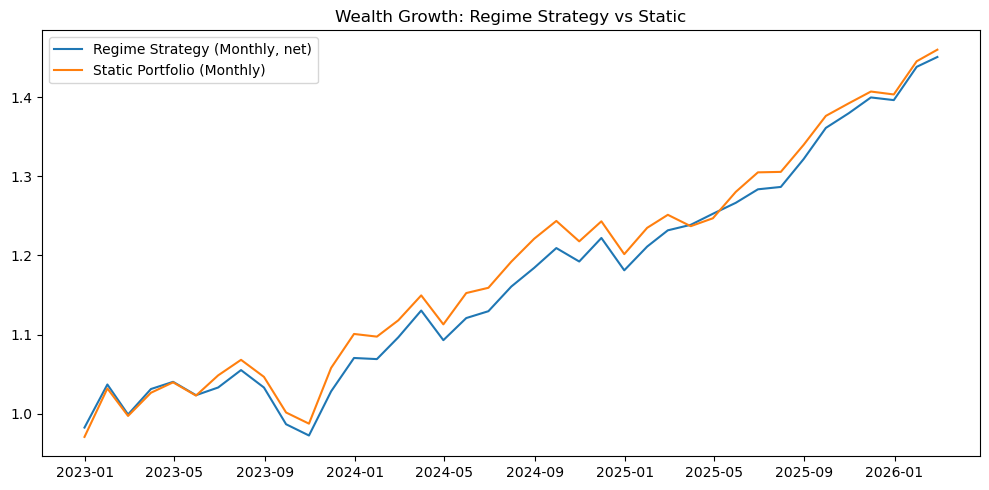

In [18]:
# ==========================================
# OPTIONAL — WEALTH CURVE PLOT + SAVE
# ==========================================

os.makedirs("results", exist_ok=True)

wealth_dynamic = (1 + dyn_monthly_net).cumprod()
wealth_static  = (1 + static_monthly).cumprod()

plt.figure(figsize=(10,5))
plt.plot(wealth_dynamic, label="Regime Strategy (Monthly, net)")
plt.plot(wealth_static,  label="Static Portfolio (Monthly)")
plt.legend()
plt.title("Wealth Growth: Regime Strategy vs Static")
plt.tight_layout()
plt.savefig("results/wealth_curve.png", dpi=200)
plt.show()


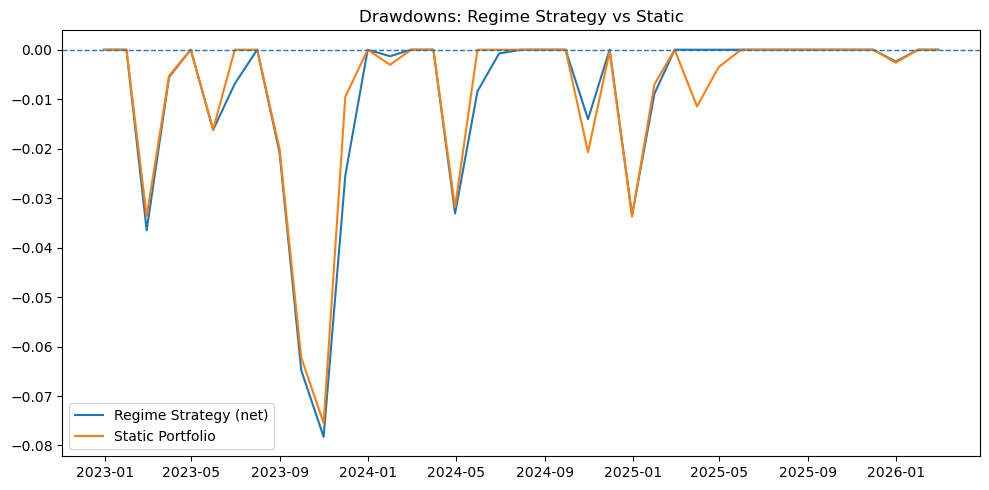

Max Drawdown (Dynamic, net): -0.07826714754687103
Max Drawdown (Static):       -0.07544719694919033


In [19]:
# ==========================================
# DRAWdown Plot (Improved + Saved to results/)
# ==========================================

def drawdown_series(r):
    """
    Drawdown series from returns.
    dd(t) = wealth(t)/peak(t) - 1
    (0 means at peak, negative means below peak)
    """
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    dd = (wealth / peak) - 1
    return dd

# Compute drawdowns
dd_dyn = drawdown_series(dyn_monthly_net)
dd_sta = drawdown_series(static_monthly)

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(dd_dyn, label="Regime Strategy (net)")
plt.plot(dd_sta, label="Static Portfolio")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend()
plt.title("Drawdowns: Regime Strategy vs Static")
plt.tight_layout()

# Save + show
plt.savefig("results/drawdowns.png", dpi=200)
plt.show()

# Optional: print max drawdowns
print("Max Drawdown (Dynamic, net):", dd_dyn.min())
print("Max Drawdown (Static):      ", dd_sta.min())


Saved: results/metrics_table.csv
Saved: data/monthly_strategy_returns.csv
Saved: results/wealth_series.csv


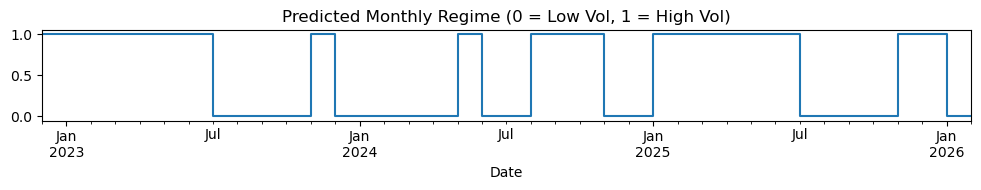

In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs("results", exist_ok=True)
os.makedirs("data", exist_ok=True)

# -----------------------------
# Save metrics table
# -----------------------------
metrics.to_csv("results/metrics_table.csv")
print("Saved: results/metrics_table.csv")

# -----------------------------
# Save monthly strategy returns
# -----------------------------
monthly_out = pd.DataFrame({
    "regime_pred": monthly_regime,
    "dyn_return_net": dyn_monthly_net,
    "static_return": static_monthly
})

monthly_out.to_csv("data/monthly_strategy_returns.csv")
print("Saved: data/monthly_strategy_returns.csv")

# -----------------------------
# Save wealth series
# -----------------------------
wealth_out = pd.DataFrame({
    "wealth_dynamic_net": (1 + dyn_monthly_net).cumprod(),
    "wealth_static": (1 + static_monthly).cumprod()
})

wealth_out.to_csv("results/wealth_series.csv")
print("Saved: results/wealth_series.csv")

# -----------------------------
# Plot regime timeline
# -----------------------------
plt.figure(figsize=(10,2))
monthly_regime.plot(drawstyle="steps-post")
plt.title("Predicted Monthly Regime (0 = Low Vol, 1 = High Vol)")
plt.tight_layout()
plt.savefig("results/monthly_regime.png", dpi=200)
plt.show()


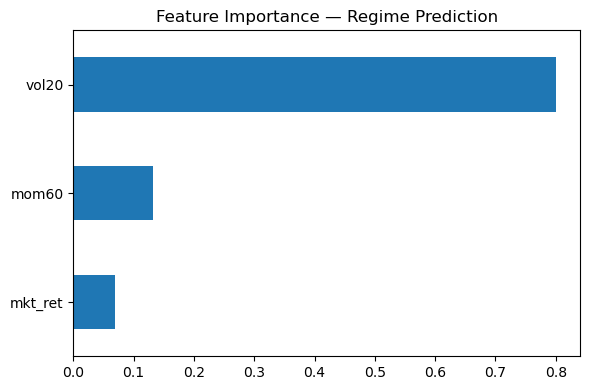

mkt_ret    0.068269
mom60      0.131434
vol20      0.800296
dtype: float64


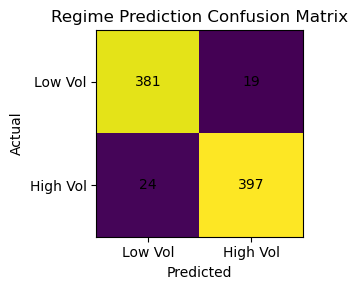

Avg Weight Turnover: 0.0987
Avg Regime Switch Rate: 0.2821
Sharpe WITH cost: 1.4254
Sharpe WITHOUT cost: 1.4552


C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1935378921.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_alt = pred_alt.resample("M").last().shift(1).dropna()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1935378921.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_alt = pred_alt.resample("M").last().shift(1).dropna()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1935378921.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_alt = pred_alt.resample("M").last().shift(1).dropna()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1935378921.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_alt = pred_alt.resample("M").last().shift(1).dropna()
C:\Users\himal\AppData\Local\Temp\ipykernel_22068\1935378921.py:119: Fut

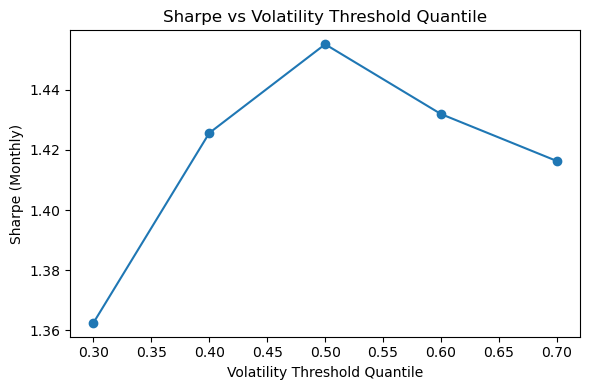

In [21]:
# ==========================================
# FINAL POLISH — Explainability + Diagnostics
# ==========================================

os.makedirs("results", exist_ok=True)

# ---------------------------------------------------------
# 1) Feature importance (train on full aligned X,y)
# ---------------------------------------------------------
# Note: fitting on full data is for interpretation only (not performance claims).
model_full = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    n_jobs=-1
)
model_full.fit(X, y)

feat_imp = pd.Series(model_full.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(6,4))
feat_imp.plot(kind="barh")
plt.title("Feature Importance — Regime Prediction")
plt.tight_layout()
plt.savefig("results/feature_importance.png", dpi=200)
plt.show()

print(feat_imp)

# ---------------------------------------------------------
# 2) Confusion matrix (OOS predictions where available)
# ---------------------------------------------------------
# Safe alignment between y and pred_series
cm_idx = y.index.intersection(pred_series.index)
y_cm = y.loc[cm_idx].astype(int)
p_cm = pred_series.loc[cm_idx].astype(int)

cm = confusion_matrix(y_cm, p_cm)

plt.figure(figsize=(4,3))
plt.imshow(cm)
plt.title("Regime Prediction Confusion Matrix")
plt.xticks([0,1], ["Low Vol", "High Vol"])
plt.yticks([0,1], ["Low Vol", "High Vol"])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# annotate counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=200)
plt.show()

# ---------------------------------------------------------
# 3) Turnover (better: weight-based turnover, not just regime switch)
# ---------------------------------------------------------
# monthly_regime should already be the shifted signal used for trading
# (monthly_regime = pred_series.resample("M").last().shift(1).dropna())
#
# Build monthly weights series
w_low = pd.Series(weights_low_vol)
w_high = pd.Series(weights_high_vol)

monthly_w = pd.DataFrame(index=monthly_regime.index, columns=w_low.index, dtype=float)
for dt in monthly_regime.index:
    monthly_w.loc[dt] = (w_low if monthly_regime.loc[dt] == 0 else w_high).values

# Turnover = sum(|w_t - w_{t-1}|) / 2
# (divide by 2 is standard convention)
turnover_w = monthly_w.diff().abs().sum(axis=1).fillna(0) / 2

avg_turnover = turnover_w.mean()

# Simple regime-switch indicator (your old version)
switch = monthly_regime.diff().abs().fillna(0)

print("Avg Weight Turnover:", round(avg_turnover, 4))
print("Avg Regime Switch Rate:", round(switch.mean(), 4))

# Compare Sharpe with/without costs (monthly)
dyn_no_cost = dyn_monthly.copy()

print("Sharpe WITH cost:", round(sharpe_ratio(dyn_monthly_net), 4))
print("Sharpe WITHOUT cost:", round(sharpe_ratio(dyn_no_cost), 4))

# ---------------------------------------------------------
# 4) Parameter sensitivity: Sharpe vs volatility threshold quantile
# (FIXED: shift monthly signal by 1 to avoid look-ahead)
# ---------------------------------------------------------
sharpes = []
q_list = [0.30, 0.40, 0.50, 0.60, 0.70]
thresholds = [vol20.quantile(q) for q in q_list]

for t in thresholds:
    # Define tomorrow regime under alternative threshold
    reg_alt = (vol20 > t).astype(int).shift(-1)

    # Align to features safely
    idx = features.index.intersection(reg_alt.index)
    X_alt = features.loc[idx]
    y_alt = reg_alt.loc[idx].dropna().astype(int)
    X_alt = X_alt.loc[y_alt.index]

    # Fit model (sensitivity check; not strict OOS)
    model_alt = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        min_samples_leaf=5,
        n_jobs=-1
    )
    model_alt.fit(X_alt, y_alt)

    pred_alt = pd.Series(model_alt.predict(X_alt), index=X_alt.index)

    # Month-end signal then shift(1) to apply next month (no look-ahead)
    monthly_alt = pred_alt.resample("M").last().shift(1).dropna()

    # Align with monthly asset returns
    common_m = monthly_returns.index.intersection(monthly_alt.index)
    mr = monthly_returns.loc[common_m]
    monthly_alt = monthly_alt.loc[common_m]

    # Build strategy returns
    alt_returns = []
    for dt in common_m:
        w = weights_low_vol if monthly_alt.loc[dt] == 0 else weights_high_vol
        alt_returns.append(sum(w[a] * mr.loc[dt, a] for a in w))

    alt_returns = pd.Series(alt_returns, index=common_m)

    # Monthly Sharpe
    sharpes.append((alt_returns.mean() / alt_returns.std()) * np.sqrt(12))

# Plot sensitivity curve
plt.figure(figsize=(6,4))
plt.plot(q_list, sharpes, marker="o")
plt.title("Sharpe vs Volatility Threshold Quantile")
plt.xlabel("Volatility Threshold Quantile")
plt.ylabel("Sharpe (Monthly)")
plt.tight_layout()
plt.savefig("results/parameter_sensitivity.png", dpi=200)
plt.show()


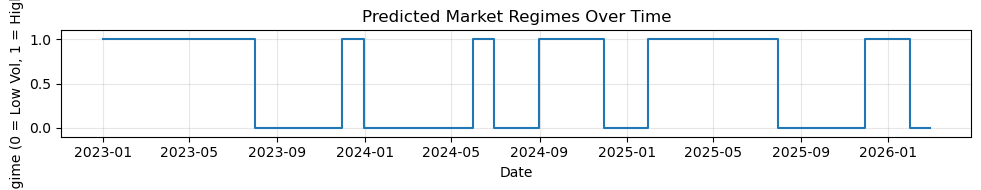

In [22]:
# ==========================================
# REGIME TIMELINE PLOT (Improved)
# ==========================================

# Make sure results folder exists
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(10,2))

# Step-style plot is best for regime switching
plt.step(monthly_regime.index, monthly_regime.values, where="post")

plt.title("Predicted Market Regimes Over Time")
plt.ylabel("Regime (0 = Low Vol, 1 = High Vol)")
plt.xlabel("Date")

plt.ylim(-0.1, 1.1)  # keeps chart clean between 0 and 1
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("results/regime_timeline.png", dpi=200)
plt.show()


In [23]:
# ==========================================
# UPGRADE 1 — PROBABILITY-WEIGHTED ALLOCATION
# ==========================================
# Goal:
# Instead of hard switching between weights_low_vol and weights_high_vol,
# we use the model’s probability of High-Vol regime to BLEND weights smoothly.
#
# If p = P(HighVol)=0.20 -> mostly low-vol (risk-on) weights
# If p = 0.80 -> mostly high-vol (defensive) weights
#
# This reduces whipsaw and is more realistic in practice.

# -----------------------------
# 1.1 Create a MONTHLY probability signal
# -----------------------------
# proba_oos is daily P(high-vol). We take month-end value and shift(1):
# - month-end: a realistic "decision point"
# - shift(1): use information at end of month t to trade month t+1 (no look-ahead)
monthly_p = proba_oos.resample("M").last().shift(1).dropna()

# Align monthly_p with monthly_returns
common_m = monthly_returns.index.intersection(monthly_p.index)
mr = monthly_returns.loc[common_m]
monthly_p = monthly_p.loc[common_m]

# -----------------------------
# 1.2 Convert weight dicts to Series (easier math)
# -----------------------------
w_low = pd.Series(weights_low_vol).sort_index()
w_high = pd.Series(weights_high_vol).sort_index()

# Make sure monthly_returns contains all assets in weights
assets_needed = w_low.index
mr = mr[assets_needed]

# -----------------------------
# 1.3 Compute probability-weighted portfolio returns (gross)
# -----------------------------
prob_monthly = []

for dt in common_m:
    p = float(monthly_p.loc[dt])  # probability of High-Vol regime

    # Blend weights smoothly:
    # w = (1-p)*low + p*high
    w = (1 - p) * w_low + p * w_high

    # Portfolio return = sum(weights * asset_returns)
    r = float((w * mr.loc[dt]).sum())
    prob_monthly.append(r)

prob_monthly = pd.Series(prob_monthly, index=common_m, name="ProbStrategy_gross")

print("Probability strategy monthly returns (gross):")
print(prob_monthly.head())


Probability strategy monthly returns (gross):
Date
2022-12-31   -0.017356
2023-01-31    0.055502
2023-02-28   -0.036446
2023-03-31    0.032137
2023-04-30    0.009001
Freq: ME, Name: ProbStrategy_gross, dtype: float64


C:\Users\himal\AppData\Local\Temp\ipykernel_22068\3976669702.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_p = proba_oos.resample("M").last().shift(1).dropna()


In [25]:
# ==========================================
# UPGRADE 2 — TURNOVER-BASED TRANSACTION COSTS
# (for probability-weighted strategy)
# ==========================================

import pandas as pd
import numpy as np

# -----------------------------
# 2.1 Rebuild monthly blended weights (store them)
# -----------------------------
# We store weights each month so we can compute turnover.

w_low = pd.Series(weights_low_vol).sort_index()
w_high = pd.Series(weights_high_vol).sort_index()

weights_monthly = pd.DataFrame(index=monthly_p.index, columns=w_low.index, dtype=float)

for dt in weights_monthly.index:
    p = float(monthly_p.loc[dt])               # P(high-vol)
    w = (1 - p) * w_low + p * w_high          # blended weights
    weights_monthly.loc[dt] = w.values

# -----------------------------
# 2.2 Compute turnover month-to-month
# -----------------------------
# Turnover = 0.5 * sum(|w_t - w_{t-1}|)
turnover_prob = (weights_monthly.diff().abs().sum(axis=1) / 2).fillna(0.0)
print("Avg turnover (prob strategy):", round(turnover_prob.mean(), 4))

# -----------------------------
# 2.3 Apply transaction costs to returns
# -----------------------------
# tcost means cost per 100% turnover (example: 0.10% = 0.001)
tcost = 0.001

# prob_monthly is your gross monthly returns from Upgrade 1
prob_monthly_net = (prob_monthly - tcost * turnover_prob).rename("ProbStrategy_net")

print("Prob strategy (net) preview:")
print(prob_monthly_net.head())


Avg turnover (prob strategy): 0.1016
Prob strategy (net) preview:
Date
2022-12-31   -0.017356
2023-01-31    0.055498
2023-02-28   -0.036448
2023-03-31    0.032135
2023-04-30    0.008997
Freq: ME, Name: ProbStrategy_net, dtype: float64


In [27]:
# ==========================================
# UPGRADE 4 — ADD BENCHMARKS
# 1) Classic 60/40 (SPY/AGG)
# 2) Simple Risk Parity (inverse-vol weights)
# ==========================================

# -----------------------------
# 4.1 Align all strategies to common monthly index
# -----------------------------
common_idx = (
    monthly_returns.index
    .intersection(prob_monthly_net.index)
    .intersection(static_monthly.index)
)

mr = monthly_returns.loc[common_idx]
prob_net = prob_monthly_net.loc[common_idx]
static_bm = static_monthly.loc[common_idx]

# -----------------------------
# 4.2 60/40 benchmark
# -----------------------------
bench_6040 = (0.60 * mr["SPY"] + 0.40 * mr["AGG"]).rename("60/40")

# -----------------------------
# 4.3 Simple Risk Parity benchmark (inverse-vol, rolling 12 months)
# -----------------------------
# Compute rolling 12-month volatility (monthly data)
vol_12m = mr.rolling(12).std()

# Inverse vol weights, normalized each month
invvol = 1 / vol_12m
rp_weights = invvol.div(invvol.sum(axis=1), axis=0).dropna()

# Align months where weights exist
common_rp = rp_weights.index.intersection(mr.index)
rp_weights = rp_weights.loc[common_rp]
mr_rp = mr.loc[common_rp, rp_weights.columns]

bench_rp = (rp_weights * mr_rp).sum(axis=1).rename("RiskParity")

print("Benchmarks ready:")
print("60/40 months:", len(bench_6040))
print("RiskParity months:", len(bench_rp))

bench_6040.head(), bench_rp.head()


Benchmarks ready:
60/40 months: 39
RiskParity months: 28


(Date
 2022-12-31   -0.039868
 2023-01-31    0.051054
 2023-02-28   -0.026704
 2023-03-31    0.031827
 2023-04-30    0.010870
 Freq: ME, Name: 60/40, dtype: float64,
 Date
 2023-11-30    0.064410
 2023-12-31    0.038189
 2024-01-31   -0.007134
 2024-02-29    0.012312
 2024-03-31    0.030946
 Freq: ME, Name: RiskParity, dtype: float64)

C:\Users\himal\AppData\Local\Temp\ipykernel_22068\3626730370.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_regime_shade = pred_series.resample("M").last().shift(1).dropna()


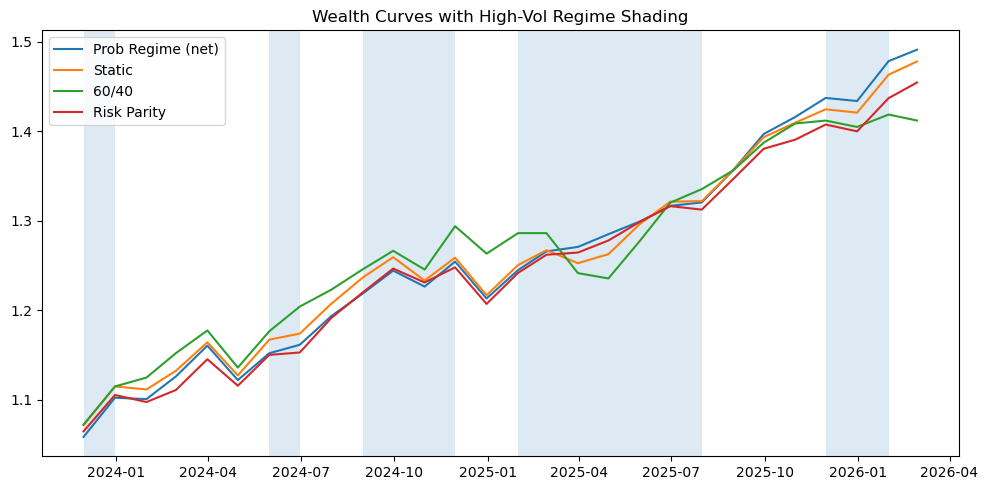

In [28]:
# ==========================================
# UPGRADE 5 — WEALTH CURVES + REGIME SHADING
# ==========================================

os.makedirs("results", exist_ok=True)

# -----------------------------
# 5.1 Build monthly regime series for shading
# -----------------------------
# monthly_regime should be the monthly binary signal used for trading.
# If you have it already, skip the next line.
monthly_regime_shade = pred_series.resample("M").last().shift(1).dropna()

# -----------------------------
# 5.2 Align everything to the same monthly index
# -----------------------------
common_all = (
    prob_net.index
    .intersection(static_bm.index)
    .intersection(bench_6040.index)
    .intersection(bench_rp.index)
    .intersection(monthly_regime_shade.index)
)

prob_net_a = prob_net.loc[common_all]
static_a   = static_bm.loc[common_all]
b6040_a    = bench_6040.loc[common_all]
rp_a       = bench_rp.loc[common_all]
reg_a      = monthly_regime_shade.loc[common_all].astype(int)

# -----------------------------
# 5.3 Wealth curves
# -----------------------------
w_prob   = (1 + prob_net_a).cumprod()
w_static = (1 + static_a).cumprod()
w_6040   = (1 + b6040_a).cumprod()
w_rp     = (1 + rp_a).cumprod()

# -----------------------------
# 5.4 Plot with high-vol shading
# -----------------------------
plt.figure(figsize=(10,5))

plt.plot(w_prob,   label="Prob Regime (net)")
plt.plot(w_static, label="Static")
plt.plot(w_6040,   label="60/40")
plt.plot(w_rp,     label="Risk Parity")

# Shade high-vol months (regime == 1)
dates = common_all
for i in range(len(dates) - 1):
    if reg_a.iloc[i] == 1:
        plt.axvspan(dates[i], dates[i+1], alpha=0.15)

plt.title("Wealth Curves with High-Vol Regime Shading")
plt.legend()
plt.tight_layout()
plt.savefig("results/wealth_with_regime_shading.png", dpi=200)
plt.show()


In [29]:
# ==========================================
# UPGRADE 6A — MODEL ROBUSTNESS CHECK
# Compare Logistic Regression vs Random Forest (time split)
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Time-based split (no shuffle)
split = int(len(X) * 0.70)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# --- Logistic Regression baseline (simple, interpretable)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# --- Random Forest (nonlinear, flexible)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("LogReg accuracy:", round(accuracy_score(y_test, pred_lr), 4))
print("RF accuracy    :", round(accuracy_score(y_test, pred_rf), 4))

print("\nLogReg classification report:\n", classification_report(y_test, pred_lr))
print("RF classification report:\n", classification_report(y_test, pred_rf))


LogReg accuracy: 0.5469
RF accuracy    : 0.9476

LogReg classification report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.12      0.21       421

    accuracy                           0.55       821
   macro avg       0.76      0.56      0.45       821
weighted avg       0.77      0.55      0.44       821

RF classification report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       400
           1       0.95      0.94      0.95       421

    accuracy                           0.95       821
   macro avg       0.95      0.95      0.95       821
weighted avg       0.95      0.95      0.95       821



In [30]:
# ==========================================
# UPGRADE 6B — REGIME ROBUSTNESS CHECK
# Compare 20-day vs 60-day volatility regime labeling
# ==========================================


# 60-day rolling volatility
vol60 = returns["SPY"].rolling(60).std()

# Median threshold for 60-day vol regime
thr60 = vol60.median()

# Regime60: 1=High vol, 0=Low vol
regime60 = (vol60 > thr60).astype(int).dropna()

print("Regime20 counts:\n", regime.value_counts())
print("\nRegime60 counts:\n", regime60.value_counts())

# Optional: how often regime20 and regime60 agree (after aligning dates)
idx = regime.index.intersection(regime60.index)
agree_rate = (regime.loc[idx] == regime60.loc[idx]).mean()

print("\nAgreement rate (Regime20 vs Regime60):", round(agree_rate, 4))


Regime20 counts:
 SPY
0    1407
1    1387
Name: count, dtype: int64

Regime60 counts:
 SPY
0    1427
1    1367
Name: count, dtype: int64

Agreement rate (Regime20 vs Regime60): 0.7989


In [33]:
print(os.getcwd())

C:\Users\himal
